# The Evaluation Theatre notebook only runs in jupyter notebook
Let JenD know if you need it with jupyter lab.

In [4]:
import doctest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score,confusion_matrix, precision_recall_fscore_support
from ipywidgets import Video, Image 

In [5]:
!jupyter nbextension list
# (you need to see both jupyter-js-widgets/extension and jupyter-video/extension enabled and validated below)
# !jupyter nbextension enable --py --sys-prefix widgetsnbextension
# !pip install Jupyter-Video_Widget
# !jupyter nbextension enable --py --sys-prefix jpy_video

Known nbextensions:
  config dir: /root/anaconda3/etc/jupyter/nbconfig
    notebook section
      jupyter-js-widgets/extension  enabled 
      - Validating: OK
      jupyter-video/extension  enabled 
      - Validating: OK


In [7]:
df = pd.read_csv('../TSN_predix_binary.csv',index_col=0,header=0)

In [5]:
# we don't have the scaled vids on this vm
df['clip_title'] = df['clip_title'].apply(lambda x: ''.join(x.split('_scaled')))

In [9]:
df.head()

,clip_title,labeler,RGB_Preds,Flow_Preds,predix,label
video-UID,,,,,,
13432,heavy_bag_drills_slice105.mp4,Lance,3,3,1,1
10918,NV_630.mp4,Jen,0,0,0,0
12665,V_980.mp4,Alex,1,0,0,0
15187,streetfight5_slice680.mp4,Ahsen,0,0,0,0
11420,SouthAmericanDrumline_slice35.mp4,Ahsen,0,0,0,0


In [15]:
# Binary case
print('Predictions')
print(df['predix'].value_counts())
print('Ground Truth')
print(df['label'].value_counts())

Predictions
0    812
1    248
Name: predix, dtype: int64
Ground Truth
0    763
1    297
Name: label, dtype: int64


In [11]:
# We are only predicting binary: punch or no punch at this time
# gt_labels = {0:'NoPunch',\
#             1:'ViolentPunchContact',\
#             2:'ViolentPunchWithoutContact',\
#             3:'NonviolentPunchContact',\
#             4:'NonviolentPunchWithoutContact'}

In [16]:
# Verify the prediction file has a column named 'predix'
def predix_col_must_be_present(x):
    """Return whether prediction file contains column named 'predix'

    >>> predix_col_must_be_present(df)
    True
    """
    return 'predix' in x.columns

# Verify we're only predicting 1=punch or else 0=no_punch at this time
# def should_predict_binary_only(x):
#     """Return set of unique values of model predictions.

#     >>> should_predict_binary_only(df)
#     {0, 1}
#     """
#     return set(x['predix'].unique())

# Verify we're not making predictions on any excluded videos
def no_excluded_videos_should_be_predicted(x):
    """Return count of videos predicted that should have been excluded
    
    >>> no_excluded_videos_should_be_predicted(df)
    0
    """
    return x.index.intersection(df[df['label'] == -1].index).shape[0]

if __name__ == '__main__':
    import doctest
    doctest.testmod()

In [17]:
df.columns

Index(['clip_title', 'labeler', 'RGB_Preds', 'Flow_Preds', 'predix', 'label'], dtype='object')

In [18]:
# Show plain old accuracy
acc = accuracy_score(y_true=df['label'],\
              y_pred=df['predix'])
print(f"Overall accuracy of this model is: {acc:.2%}")

Overall accuracy of this model is: 86.32%


In [20]:
# Show precision_recall_fscore_support per label JUST BINARY FOR NOW
raw_report = precision_recall_fscore_support(y_true=df['label'], y_pred=df['predix'])
report = pd.DataFrame(raw_report, index=['precision','recall','fscore','support'],\
                     columns = ['NoPunch','Punch'])
report

,NoPunch,Punch
precision,0.880542,0.806452
recall,0.937090,0.673401
fscore,0.907937,0.733945
support,763.000000,297.000000


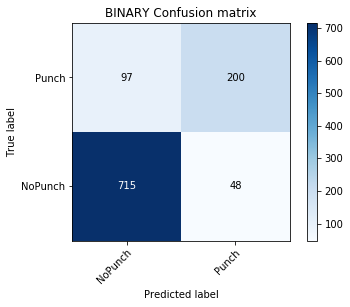

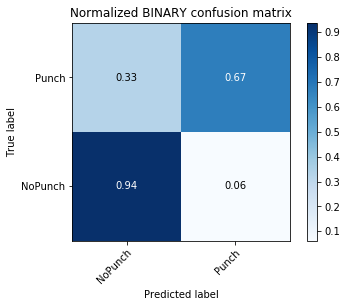

In [24]:
def plot_confusion_matrix(y_true, y_pred, labels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_xlim(left=-0.5, right=1.5)
    ax.set_ylim(bottom=-0.5, top=1.5)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax


np.set_printoptions(precision=2)
labels=['NoPunch','Punch']
# Plot non-normalized confusion matrix
plot_confusion_matrix(df['label'], df['predix'], labels=labels,
                      title='BINARY Confusion matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(df['label'], df['predix'], labels=labels, normalize=True,
                      title='Normalized BINARY confusion matrix')

plt.show()

In [25]:
# Binary samples
def resample():
    samples={}
    for truth in range(0,2):  # binary here
        samples[truth]={}
        for pred in range(0,2):  # binary here, too
            if bool(df[(df['label']==truth) & (df['predix']==pred)].shape[0]):
                samples[truth][pred] = df[(df['label']==truth) & (df['predix']==pred)].sample(1)
    return samples

In [26]:
def fetch_sample(real,predicted,sampledict):
    truth_target = sampledict.get(real,None)
    if truth_target:
        pred_target = truth_target.get(predicted,None)
        return pred_target

The clips that have ground truth of no punch and are also predicted as no punch are the vast majority of our clips. Load the below cell several times for some examples:

In [30]:
show = None
c00 = fetch_sample(0,0,resample())
truth,inference = 'NO-PUNCH','same'
if 'DataFrame' in str(type(c00)):
    clip, judge = c00.head(1)['clip_title'].iloc[0],c00.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

NO-PUNCH clip predicted as same [HShackeysack_slice45.mp4 brought to you by Ahsen]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x07\x1a(mdat\x00\x…

In 48 cases, our TSN predicts a punch where there is none labeled. In looking at samples of these, some are shoves and slaps that could be flagged by humans, for example V_765.mp4 and streetfight5_slice500.mp4). Many warrant further attention from security professionals, and in our edge-screening scenario, they would be sent to the cloud for further analysis.

In [55]:
show = None
c01 = fetch_sample(0,1,resample())
truth,inference = 'NO-PUNCH','PUNCH'
if 'DataFrame' in str(type(c01)):
    clip, judge = c01.head(1)['clip_title'].iloc[0],c01.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

NO-PUNCH clip predicted as PUNCH [V_813_slice0.mp4 brought to you by Jen]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xc6\xe2mdat\x0…

What about the clips that were labeled as containing a punch, yet are not predicted to contain a punch? Play some examples below.

In [69]:
show = None
c10 = fetch_sample(1,0,resample())
truth,inference = 'PUNCH','NO-PUNCH'
if 'DataFrame' in str(type(c10)):
    clip, judge = c10.head(1)['clip_title'].iloc[0],c10.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

PUNCH clip predicted as NO-PUNCH [French_flashmob_circle_slice345.mp4 brought to you by Lance]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x1b\xe2\xd1mdat\x0…

Below, watch clips that were properly predicted to contain a punch

In [62]:
show = None
c11 = fetch_sample(1,1,resample())
truth,inference = 'PUNCH','same'
if 'DataFrame' in str(type(c11)):
    clip, judge = c11.head(1)['clip_title'].iloc[0],c11.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

PUNCH clip predicted as same [V_256.mp4 brought to you by Lance]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08j\xa7mdat\x00\x…